In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps
import pandas as pd
import csv

In [2]:
train_path = 'recog_data/data/training_data'
test_path = 'recog_data/data/testing_data'

In [3]:
import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
def map_label(char_array):
    result = []
    for char in char_array:
        if char.isdigit():
            result.append(int(char))
        elif char.isalpha():
            result.append(ord(char.upper()) - ord('A') + 10)
        else:
            result.append(None)
    return np.array(result, dtype=np.int64) 

def map_result(result_array):
    char = []
    for num in result_array:
        if 0 <= num <= 9:
            char.append(str(num))
        elif 10 <= num <= 35:
            char.append(chr(ord('A') + num - 10))
        else:
            char.append(None)
    
    return ''.join([str(c) for c in char if c is not None])

In [6]:
char_list = os.listdir(train_path)

In [7]:
data_sequence_length = 10000
seq_len = 5
sequence_dataset = []
label_dataset = []

In [8]:
for i in range(data_sequence_length):
    selected_indices = np.random.choice(char_list, size=seq_len, replace=False)
    transformed_image = []

    for char in selected_indices:
        char_path = os.path.join(train_path, char)
        image_file = np.random.choice(os.listdir(char_path), size=1)[0]
        image_path = os.path.join(char_path, image_file)
        
        img = Image.open(image_path)
        img = img.resize((32, 32))
        img = ImageOps.autocontrast(img)
        img = ImageOps.invert(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.0))(img)
        img = transforms.ToTensor()(img).numpy()

        transformed_image.append(img)
        
    transformed_image = np.array(transformed_image)
    sequence = np.hstack(transformed_image.reshape(seq_len, 32, 32))
    labels = np.hstack(selected_indices.reshape(seq_len, 1))
    labels = np.array(map_label(labels))
    sequence_dataset.append(sequence / 255)
    label_dataset.append(labels)

In [9]:
dataset_data = torch.Tensor(np.array(sequence_dataset))
dataset_labels = torch.IntTensor(np.array(label_dataset))

seq_dataset = torch.utils.data.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.9), int(len(seq_dataset) * 0.1)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [10]:
cnn_output_height = 5
cnn_output_width = 37
gru_hidden_size = 128
gru_num_layers = 2
lstm_hidden_size = 128
lstm_num_layers = 2
num_classes = len(char_list)+1

In [11]:
class CRNN_GRU(nn.Module):
    def __init__(self):
        super(CRNN_GRU, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, 
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x): # 64,1,32,160
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out) # 64,32,30,158
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out) # 64,32,14,78
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out) # 64,64,12,76
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out) # 64,64,5,37
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out) # 64, 37, 256
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [ ]:
class CRNN_LSTM(nn.Module):
    def __init__(self):
        super(CRNN_LSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.lstm_input_size = cnn_output_height * 64
        self.lstm = nn.LSTM(self.lstm_input_size, lstm_hidden_size, lstm_num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)

    def forward(self, x): # 64,1,32,160
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out) # 64,32,30,158
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out) # 64,32,14,78
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out) # 64, 64, 12, 76
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out) # 64, 64, 5, 37
        out = out.reshape(batch_size, -1, self.lstm_input_size)
        out, _ = self.lstm(out) # 64, 37, 256
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out


In [12]:
blank_label = 36
model = CRNN_GRU().to(device)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
from itertools import groupby

In [14]:
epochs = 50
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    # ============================================ TRAINING =====================================================
    model.train()
    model.to(device)
    
    train_correct = 0
    train_total = 0
    running_train_loss = 0.0
    
    for x_train, y_train in train_loader:
        batch_size = x_train.shape[0]
        x_train = x_train.view(batch_size, 1, x_train.shape[1], x_train.shape[2])

        optimizer.zero_grad()
        y_pred = model(x_train.to(device))
        y_pred = y_pred.permute(1, 0, 2)
        
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train.to(device), input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        _, max_index = torch.max(y_pred, dim=2)
        for step in range(batch_size):
            raw_prediction = list(max_index[:, step].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[step]) and torch.all(prediction.eq(y_train.cpu()[step])):
                train_correct += 1
            train_total += 1
    
    train_average_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_loss.append(train_average_loss)
    train_acc.append(train_accuracy)
    
    # ============================================ VALIDATION ===================================================
    model.eval()
    val_correct = 0
    val_total = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            batch_size = x_val.shape[0]
            x_val = x_val.view(batch_size, 1, x_val.shape[1], x_val.shape[2])
            y_pred_val = model(x_val.to(device))
            y_pred_val = y_pred_val.permute(1, 0, 2)
            input_lengths_val = torch.IntTensor(batch_size).fill_(cnn_output_width)
            target_lengths_val = torch.IntTensor([len(t) for t in y_val])
            loss_val = criterion(y_pred_val, y_val.to(device), input_lengths_val, target_lengths_val)
            running_val_loss += loss_val.item()
            
            _, max_index_val = torch.max(y_pred_val, dim=2)
            for i in range(batch_size):
                raw_prediction_val = list(max_index_val[:, i].detach().cpu().numpy())
                prediction_val = torch.IntTensor([c for c, _ in groupby(raw_prediction_val) if c != blank_label])
                if len(prediction_val) == len(y_val[i]) and torch.all(prediction_val.eq(y_val[i])):
                    val_correct += 1
                val_total += 1
    
    val_average_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_loss.append(val_average_loss)
    val_acc.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_average_loss:.4f}, Train Accuracy: {train_correct}/{train_total} = {train_accuracy:.4f}, Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_correct}/{val_total} = {val_accuracy:.4f}')


Epoch [1/50] Train Loss: 0.0671, Train Accuracy: 0/9000 = 0.0000, Val Loss: 3.9049, Val Accuracy: 0/1000 = 0.0000
Epoch [2/50] Train Loss: 0.0604, Train Accuracy: 0/9000 = 0.0000, Val Loss: 3.7133, Val Accuracy: 0/1000 = 0.0000
Epoch [3/50] Train Loss: 0.0513, Train Accuracy: 0/9000 = 0.0000, Val Loss: 2.7819, Val Accuracy: 1/1000 = 0.0010
Epoch [4/50] Train Loss: 0.0369, Train Accuracy: 27/9000 = 0.0030, Val Loss: 1.9337, Val Accuracy: 4/1000 = 0.0040
Epoch [5/50] Train Loss: 0.0257, Train Accuracy: 222/9000 = 0.0247, Val Loss: 1.4503, Val Accuracy: 34/1000 = 0.0340
Epoch [6/50] Train Loss: 0.0189, Train Accuracy: 796/9000 = 0.0884, Val Loss: 1.1298, Val Accuracy: 101/1000 = 0.1010
Epoch [7/50] Train Loss: 0.0144, Train Accuracy: 1542/9000 = 0.1713, Val Loss: 0.9974, Val Accuracy: 132/1000 = 0.1320
Epoch [8/50] Train Loss: 0.0115, Train Accuracy: 2376/9000 = 0.2640, Val Loss: 0.8643, Val Accuracy: 183/1000 = 0.1830
Epoch [9/50] Train Loss: 0.0093, Train Accuracy: 3086/9000 = 0.3429, V

In [15]:
# Define paths for saving the model checkpoint
checkpoint_path = "recognizer_10k_2.pth"

# Save the checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'train_acc': train_acc,
}, checkpoint_path)

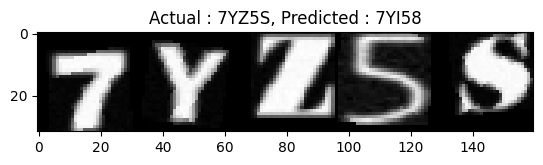

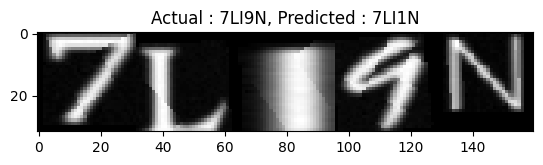

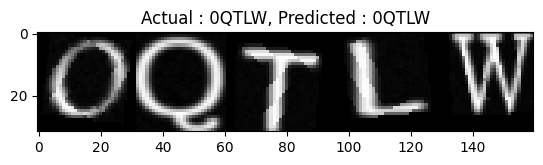

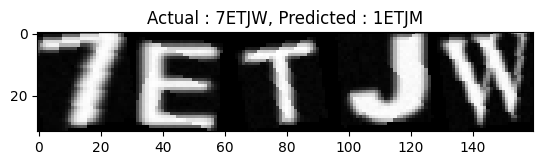

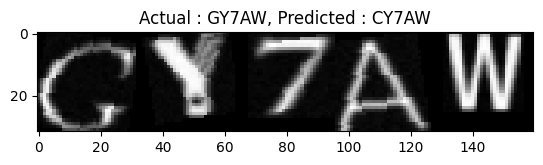

In [16]:
number_of_test_imgs = 5
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    plt.imshow(x_test[j], cmap='gray')
    plt.title(f'Actual : {str(map_result(y_test[j].numpy()))}, Predicted : {str(map_result(test_preds[j].numpy()))}')
    plt.show()